# Soccer Learning
By: Jacob Klein & Omar Pardo

**NOTE:**

To run, please clone [this folder](https://drive.google.com/open?id=1n4DOiOmSHWvw1n4kres5IlTaFboOUP7s) to your Columbia Drive (ensure the folder ADL is available directly from the root of your drive)

The video presentation is available at the following [Youtube link](https://youtu.be/e42zLM_n4yA)

## Caveat: This notebook is intended to be run using Colab, and having the data in a Drive folder to which the user has access.

## Several sections of this file were inspired by this [notebook](https://github.com/random-forests/adl-fall-19/blob/master/a4.ipynb) written by Prof. Joshua Gordon.

## Import libraries

In [0]:
try:
    %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
import os
import csv
import random
import time

In [0]:
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

## Set paths

In [0]:
colab_root = "/content/" 
drive_root = "drive/My Drive/" + "ADL/" # CHANGE THIS TO THE DRIVE FOLDER WHERE YOU STORE THE DATA

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
labels_path = os.path.join(drive_root, "labels.csv")
images_path = os.path.join(drive_root, "clasico_frames.zip")

## Load data

In [0]:
!cp "$labels_path" .

In [0]:
!cp "$images_path" .

In [0]:
images_folder = os.path.join(colab_root, 'clasico_frames/')

In [0]:
!unzip -q clasico_frames.zip -d .

In [0]:
!ls

clasico_frames	clasico_frames.zip  drive  labels.csv  sample_data


## Exploratory Data Analysis


In [0]:
labels_df = pd.read_csv('labels.csv')
labels_df

frame  label
0         0      0
1        10      0
2        20      0
3        30      0
4        40      0
...     ...    ...
8578  85780      3
8579  85790      3
8580  85800      3
8581  85810      3
8582  85820      3

[8583 rows x 2 columns]

In [0]:
def get_human_label(label):
    if label == 0:
        return('death ball')
    elif label == 1:
        return('real madrid')
    elif label == 2:
        return('barcelona')
    elif label == 3:
        return('replay')

In [0]:
labels_ = labels_df.copy()
labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * 3)

### What is the frequency of every label?

In [0]:
minutes_per_label = labels_.groupby('human_label')['minutes']\
                           .sum()\
                           .reset_index()\
                           .sort_values('minutes', ascending = False)

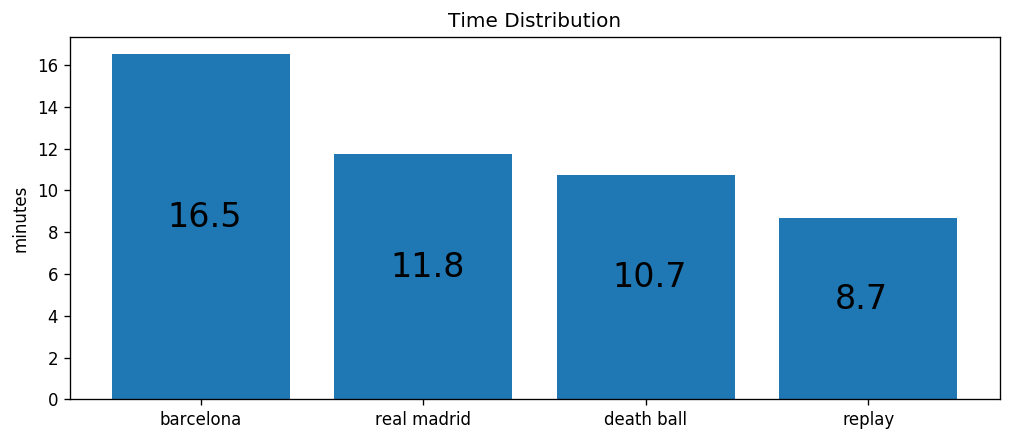

In [0]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
plt.bar(minutes_per_label['human_label'], minutes_per_label['minutes'])

for i, v in enumerate(minutes_per_label['minutes']):
    plt.text(i - 0.15, v / 2, str(round(v, 1)), size = 20)

plt.ylabel('minutes')    
plt.title('Time Distribution')
plt.show()

### Does this change throughout time?

In [0]:
pivot_labels = pd.pivot_table(labels_, values='minutes', index=['frame'],
                              columns=['human_label'], aggfunc=np.sum, fill_value=0)

pivot_labels['frame'] = pivot_labels.index
pivot_labels = pivot_labels.reset_index(drop=True).rename_axis(None, axis=1)

cum_pivot_labels = pivot_labels.copy()
cum_pivot_labels['barcelona'] = np.cumsum(pivot_labels['barcelona'])
cum_pivot_labels['real madrid'] = np.cumsum(pivot_labels['real madrid'])
cum_pivot_labels['death ball'] = np.cumsum(pivot_labels['death ball'])
cum_pivot_labels['replay'] = np.cumsum(pivot_labels['replay'])

cum_pivot_labels = cum_pivot_labels[['frame', 'barcelona', 'real madrid', 'death ball', 'replay']]

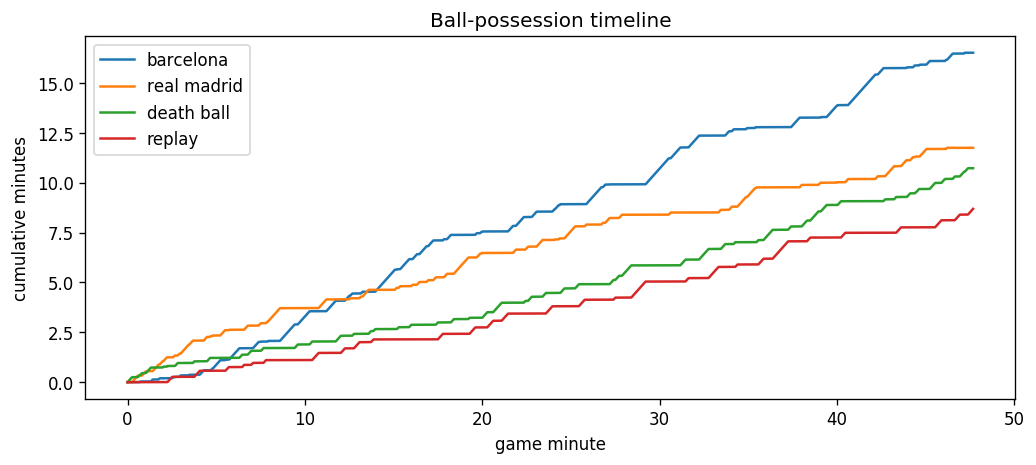

In [0]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
minutes = cum_pivot_labels['frame'] / (10 * 3 * 60)
df_minutes_labels = cum_pivot_labels.drop('frame', axis = 1)
for label in list(df_minutes_labels):
    plt.plot(minutes, df_minutes_labels[label], label = label)

plt.xlabel('game minute')
plt.ylabel('cumulative minutes')
plt.legend()
plt.title('Ball-possession timeline')
plt.show()

### Why there are several jumps in the series? 

In [0]:
time_unit = 1 / 3
current_label = labels_['human_label'][0]
length = 0
sequences = []

for label in labels_['human_label'][:-1]:
    if label == current_label:
        length += time_unit
    else:
        sequences.append((current_label, length))
        current_label = label
        length = time_unit
sequences.append((current_label, length+time_unit)) 
sequences = pd.DataFrame(sequences)
sequences.columns = ['label', 'seconds']

top_sequences = sequences.sort_values('seconds', ascending=False).head(20)

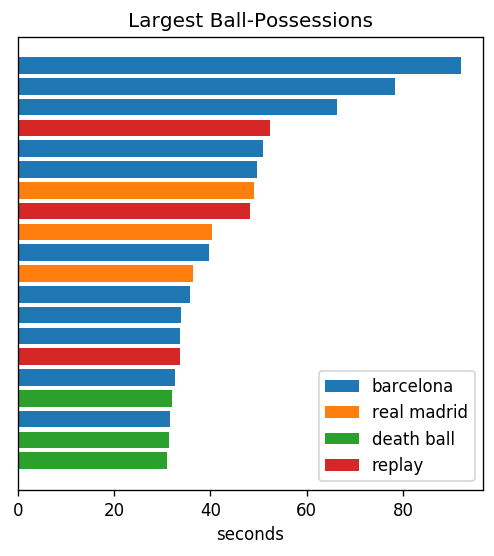

In [0]:
fig, axes = plt.subplots(figsize=(5,5), dpi=120)

y_values = np.arange(top_sequences.shape[0],0,-1)
labels_ = ['barcelona', 'real madrid', 'death ball', 'replay']

for label in labels_:
    mask = top_sequences['label'] == label
    plt.barh(y_values[mask], top_sequences['seconds'][mask], label = label)

plt.legend()
plt.yticks([])
plt.xlabel('seconds')
plt.title('Largest Ball-Possessions')
plt.show()

## Data Wrangling

In [0]:
def frame_num_to_image_path(frame):
    return(os.path.join(colab_root, "clasico_frames/frame%s.jpg" % frame))

labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

frame  label                                img_path
0         0      0      /content/clasico_frames/frame0.jpg
1        10      0     /content/clasico_frames/frame10.jpg
2        20      0     /content/clasico_frames/frame20.jpg
3        30      0     /content/clasico_frames/frame30.jpg
4        40      0     /content/clasico_frames/frame40.jpg
...     ...    ...                                     ...
8578  85780      3  /content/clasico_frames/frame85780.jpg
8579  85790      3  /content/clasico_frames/frame85790.jpg
8580  85800      3  /content/clasico_frames/frame85800.jpg
8581  85810      3  /content/clasico_frames/frame85810.jpg
8582  85820      3  /content/clasico_frames/frame85820.jpg

[8583 rows x 3 columns]

Tag: death ball


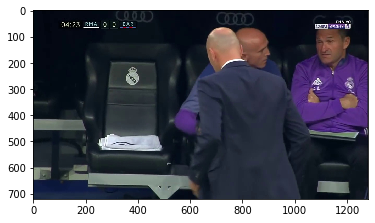

Tag: real madrid


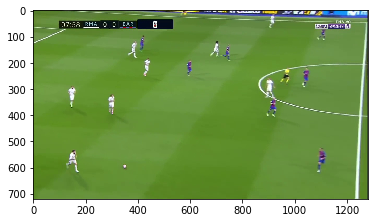

Tag: barcelona


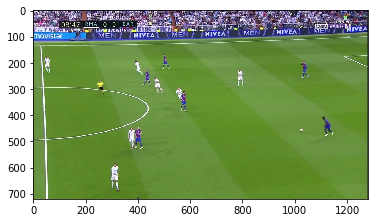

Tag: barcelona


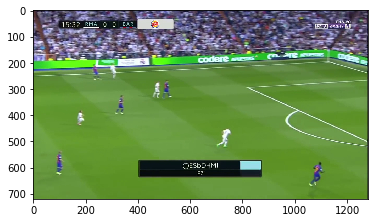

Tag: real madrid


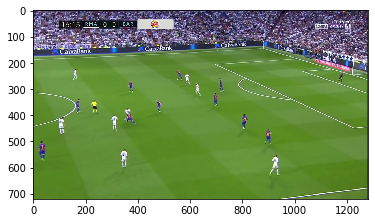

Tag: replay


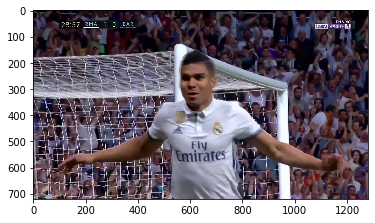

In [0]:
random.seed(1234)
for index, row in labels_df.iterrows():
    frame = row['frame']
    label = row['label']
    img_path = row['img_path']

    # Verify the image is in the folder
    assert os.path.exists(img_path)   

  # Shows some images
    if random.random() < 0.001:
        image_ = mpimg.imread(img_path)
        print('Tag: %s' % get_human_label(label))
        plt.gca().clear()
        plt.imshow(image_)
        plt.show()      

## Split train, validation and test 

We are going to train using only the first 15 minutes, and see if we can predict the next 30.

In [0]:
FRAME_THRESHOLD = 2720 #First 15 minutes
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:-7] #ensuring batch size of 32
train, val = train_test_split(train_val, test_size=0.2, random_state=2019)

## Save activations from Inception V3 for all the images

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 4s 0us/step


In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. 
def image_to_activations(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    activations = tf.keras.applications.inception_v3.preprocess_input(img)
    return activations, image_path

In [0]:
image_path_set = set(labels_df['img_path'])

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 8583
This make take a few minutes


In [0]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. 

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

## Convert data to an appropiate batch format to train the model

In [0]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
def load_np(img_path, label):
    activations = np.load(img_path.decode('utf-8')+'.npy')
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
train_ds = create_dataset(images_train, labels_train, shuff = False)
val_ds = create_dataset(images_val, labels_val, shuff = False)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [0]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

print(activations_batch, 
      labels_batch, 
      paths_batch)

(32, 8, 8, 2048) (32,) (32,)
tf.Tensor(
[[[[0.79987717 0.         0.12068588 ... 0.         0.
    0.        ]
   [1.4923997  0.         0.8630913  ... 0.         0.
    0.        ]
   [1.7172709  0.         0.21555604 ... 0.68748385 0.
    0.        ]
   ...
   [0.70036966 0.37277827 0.7042545  ... 1.3974127  0.
    0.        ]
   [1.1723187  0.         0.75140595 ... 0.779182   0.11017187
    0.        ]
   [0.6293468  0.         0.         ... 0.64521873 0.1884428
    0.        ]]

  [[1.247969   0.2918897  0.         ... 0.         0.11427155
    0.        ]
   [1.7276027  0.13338281 0.01518827 ... 0.         0.
    0.        ]
   [0.8496784  0.5847686  0.         ... 0.         0.
    0.        ]
   ...
   [0.         1.0549517  0.         ... 0.2109843  0.
    0.        ]
   [0.21328613 0.         0.         ... 0.00881417 0.08639662
    0.        ]
   [0.15197417 0.         0.         ... 0.         0.0438764
    0.        ]]

  [[1.1436005  0.22154577 0.         ... 0.         

## CNN Approach

### Design the CNN

In [0]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 135,556
Trainable params: 135,556
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

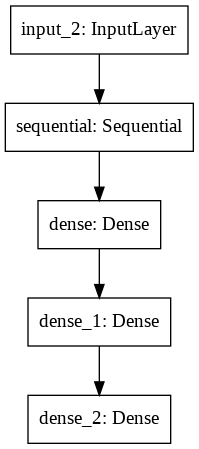

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [0]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [0]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [0]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.001662
Accuracy: 1.000000


In [0]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[5.17504413e-05 2.15732679e-03 9.97776687e-01 1.42998715e-05] 2.0
[9.9930310e-01 7.6622724e-05 6.1932881e-04 9.8377450e-07] 0.0
[9.0486923e-05 9.9968004e-01 2.2844502e-04 1.0840116e-06] 1.0
[1.1966884e-04 9.1317249e-04 9.9884713e-01 1.1999935e-04] 2.0
[7.1771245e-04 4.6906983e-03 9.9401629e-01 5.7524146e-04] 2.0
[2.0229218e-05 3.4339627e-04 9.9960190e-01 3.4462584e-05] 2.0
[7.1365357e-04 9.9253124e-01 6.6575399e-03 9.7577351e-05] 1.0
[3.2499360e-04 1.1346437e-04 9.9902093e-01 5.4054655e-04] 2.0
[2.9496252e-07 9.9132294e-06 9.9998713e-01 2.5714421e-06] 2.0
[1.5031550e-03 1.5230138e-04 9.9679774e-01 1.5467640e-03] 2.0
[9.9878007e-01 5.0307479e-04 6.1763223e-04 9.9307174e-05] 0.0
[4.9311711e-05 9.9899429e-01 9.3313406e-04 2.3247043e-05] 1.0
[3.9962015e-05 6.7824854e-05 9.9984407e-01 4.8196132e-05] 2.0
[8.0972502e-05 2.0287444e-03 9.9786997e-01 2.0389136e-05] 2.0
[1.0567933e-03 9.9885428e-01 7.8301731e-05 1.0690055e-05] 1.0
[3.3191658e-04 2.0264813e-05 1.6361815e-03 9.9801159e-01] 3.0
[9.9

### Manage checkpoints in case we want to fit the model for a long time

In [0]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/CNN_")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is drive/My Drive/ADL/soccer_checkpoints/CNN_
Creating a checkpoints directory


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Fit the model

In [0]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [0]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 1.01, Accuracy: 63.14, Val Loss 0.74, Val Accuracy 68.93, Time: 4.0 secs
Saving weights
Epoch 1, Loss: 0.59, Accuracy: 76.79, Val Loss 0.60, Val Accuracy 74.08, Time: 2.7 secs
Saving weights
Epoch 2, Loss: 0.48, Accuracy: 81.71, Val Loss 0.54, Val Accuracy 77.94, Time: 2.4 secs
Saving weights
Epoch 3, Loss: 0.39, Accuracy: 86.26, Val Loss 0.51, Val Accuracy 78.49, Time: 2.4 secs
Saving weights
Epoch 4, Loss: 0.32, Accuracy: 88.47, Val Loss 0.49, Val Accuracy 80.15, Time: 2.4 secs
Saving weights
Epoch 5, Loss: 0.28, Accuracy: 90.49, Val Loss 0.48, Val Accuracy 81.25, Time: 2.4 secs
Saving weights
Epoch 6, Loss: 0.25, Accuracy: 91.59, Val Loss 0.50, Val Accuracy 80.33, Time: 2.4 secs
Saving weights
Epoch 7, Loss: 0.23, Accuracy: 91.77, Val Loss 0.45, Val Accuracy 81.80, Time: 2.4 secs
Saving weights
Epoch 8, Loss: 0.27, Accuracy: 89.25, Val Loss 0.44, Val Accuracy 84.01, Time: 2.5 secs
Saving weights
Epoch 9, Loss: 0.22, Accuracy: 92.10, Val Loss 0.43, Val Accuracy 83.27, 

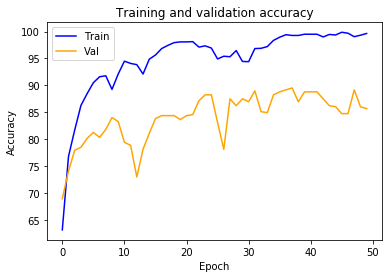

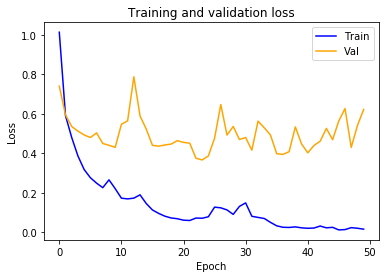

In [0]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [0]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from drive/My Drive/ADL/soccer_checkpoints/CNN_/cp-00000049.ckpt


True label: replay
Predicted label: replay
Confidence of the prediction: 0.97603285


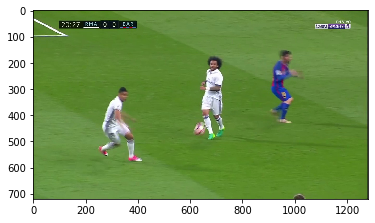

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.9973816


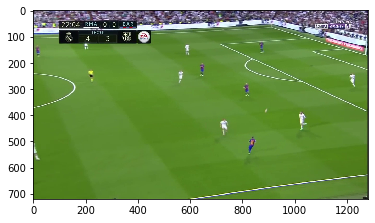

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.9995109


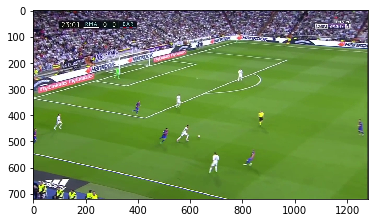

True label: death ball
Predicted label: death ball
Confidence of the prediction: 0.99976474


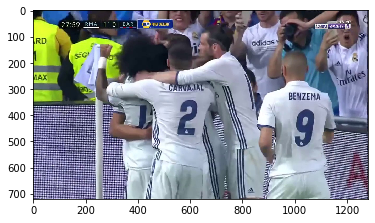

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.99306387


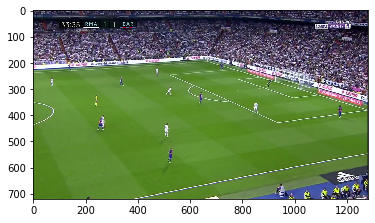

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 1.0


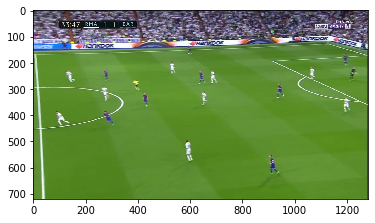

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.9990006


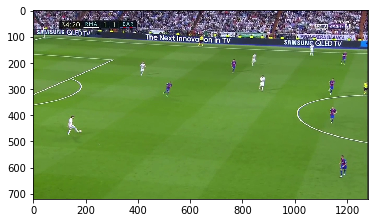

True label: replay
Predicted label: replay
Confidence of the prediction: 0.9845019


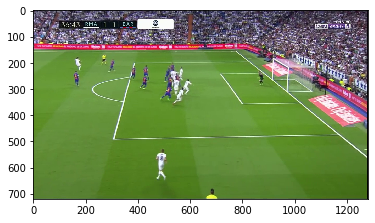

True label: death ball
Predicted label: barcelona
Confidence of the prediction: 0.99264467


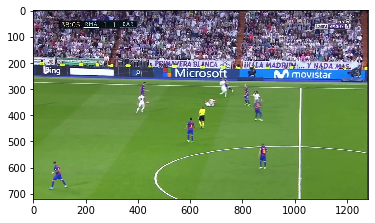

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.9999044


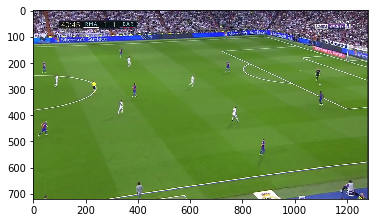

True label: barcelona
Predicted label: death ball
Confidence of the prediction: 0.94624346


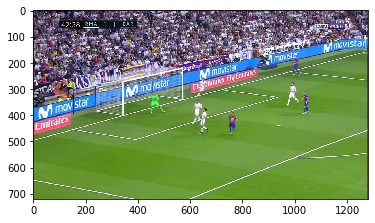

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.96851975


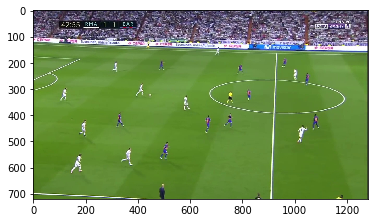

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 1.0


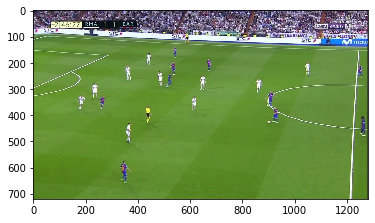

True label: replay
Predicted label: death ball
Confidence of the prediction: 1.0


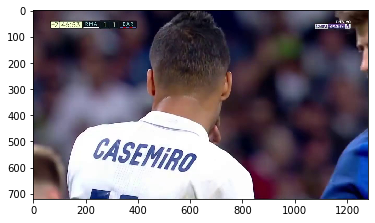

In [0]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [0]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.554474


In [0]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [0]:
predictions_cnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_cnn

img_path  frame  ...  pred_label  confidence
0     /content/clasico_frames/frame27200.jpg  27200  ...           0    1.000000
1     /content/clasico_frames/frame27210.jpg  27210  ...           0    1.000000
2     /content/clasico_frames/frame27220.jpg  27220  ...           0    1.000000
3     /content/clasico_frames/frame27230.jpg  27230  ...           0    0.999944
4     /content/clasico_frames/frame27240.jpg  27240  ...           0    1.000000
...                                      ...    ...  ...         ...         ...
5851  /content/clasico_frames/frame85710.jpg  85710  ...           3    0.840660
5852  /content/clasico_frames/frame85720.jpg  85720  ...           2    0.999964
5853  /content/clasico_frames/frame85730.jpg  85730  ...           2    0.999997
5854  /content/clasico_frames/frame85740.jpg  85740  ...           2    0.999983
5855  /content/clasico_frames/frame85750.jpg  85750  ...           2    0.999382

[5856 rows x 5 columns]

In [0]:
pred_labels = pd.Series(map(get_human_label, predictions_cnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_cnn['label']))

In [0]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred         barcelona  death ball  real madrid    replay       All
label                                                              
barcelona     0.253928    0.017418     0.056523  0.006489  0.334358
death ball    0.056182    0.109802     0.022541  0.059426  0.247951
real madrid   0.147541    0.007343     0.058060  0.004781  0.217725
replay        0.036373    0.027493     0.003415  0.132684  0.199966
All           0.494023    0.162056     0.140540  0.203381  1.000000

#### Recall

In [0]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.759448    0.052094     0.169050  0.019408
death ball    0.226584    0.442837     0.090909  0.239669
real madrid   0.677647    0.033725     0.266667  0.021961
replay        0.181896    0.137489     0.017079  0.663535

#### Precision

In [0]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.513999    0.107482     0.402187  0.031906
death ball    0.113723    0.677555     0.160389  0.292191
real madrid   0.298652    0.045311     0.413123  0.023510
replay        0.073626    0.169652     0.024301  0.652393

## CNN + RNN Approach

### Design the CNN + RNN

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, GRU, Concatenate
from tensorflow.keras.models import Model, Sequential

image_input = Input(shape=(8, 8, 2048), batch_size=32) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(GlobalAveragePooling2D())
encoded_image = vision_model(image_input)
encoded_image_drop = Dropout(0.5)(encoded_image)

# Adding Gated Recurred Units
encoded_image_reshape = Reshape((1, 2048))(encoded_image_drop)
gru_1 = GRU(32, stateful=True, dropout=0.3, recurrent_dropout=0.3)(encoded_image_reshape)
#gru_2 = GRU(64, stateful=True, dropout=0.3, recurrent_dropout=0.3)(gru_1)

# Combining both CNN and RNN outputs
x = Concatenate()([gru_1, encoded_image_drop])

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(x)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

model = Model(inputs=image_input, outputs=output)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 8, 8, 2048)]   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (32, 2048)           0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (32, 2048)           0           sequential_1[0][0]               
__________________________________________________________________________________________________
reshape (Reshape)               (32, 1, 2048)        0           dropout[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

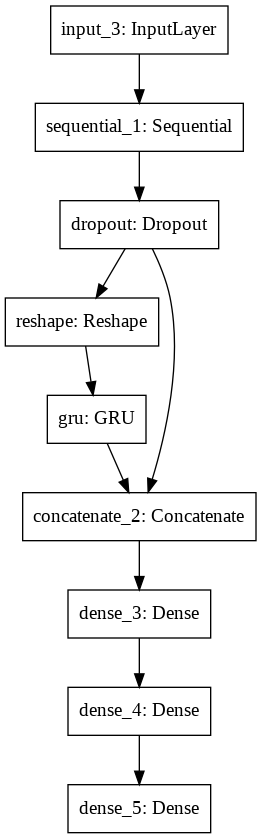

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [0]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [0]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [0]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.006477
Accuracy: 1.000000


In [0]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[1.4375372e-07 2.6660620e-03 9.9733222e-01 1.5941499e-06] 2.0
[9.9988115e-01 3.1764866e-05 3.6336238e-05 5.0750623e-05] 0.0
[1.6918519e-04 9.9917477e-01 6.0331548e-04 5.2785235e-05] 1.0
[2.7057359e-07 5.3009856e-04 9.9946231e-01 7.3289871e-06] 2.0
[8.821699e-06 3.318717e-03 9.966107e-01 6.172418e-05] 2.0
[5.9700035e-08 2.1170659e-04 9.9978715e-01 1.0474729e-06] 2.0
[2.8615142e-04 9.7512472e-01 2.3950513e-02 6.3851388e-04] 1.0
[7.7966497e-06 1.7019830e-04 9.9967551e-01 1.4646974e-04] 2.0
[2.2577712e-10 2.0030513e-05 9.9997973e-01 2.3591069e-07] 2.0
[1.45504355e-05 2.51020538e-04 9.99562562e-01 1.71776366e-04] 2.0
[9.9909306e-01 1.2250837e-04 7.8340468e-05 7.0605404e-04] 0.0
[1.0063433e-05 9.9574161e-01 3.5889880e-03 6.5928797e-04] 1.0
[1.05244716e-07 2.54142815e-05 9.99970436e-01 4.05908213e-06] 2.0
[3.3280875e-07 1.1905981e-03 9.9880314e-01 5.9538811e-06] 2.0
[3.7441874e-04 9.9864572e-01 7.7669678e-04 2.0316278e-04] 1.0
[1.8572834e-04 1.9202096e-04 5.6958286e-04 9.9905258e-01] 3.0
[9.9

### Manage checkpoints in case we want to fit the model for a long time

In [0]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/RNN")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is drive/My Drive/ADL/soccer_checkpoints/RNN
Creating a checkpoints directory


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Fit the model

In [0]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [0]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 1.11, Accuracy: 58.04, Val Loss 0.81, Val Accuracy 67.10, Time: 2.6 secs
Saving weights
Epoch 1, Loss: 0.76, Accuracy: 67.74, Val Loss 0.70, Val Accuracy 73.53, Time: 2.6 secs
Saving weights
Epoch 2, Loss: 0.70, Accuracy: 71.83, Val Loss 0.68, Val Accuracy 73.71, Time: 2.6 secs
Saving weights
Epoch 3, Loss: 0.64, Accuracy: 72.56, Val Loss 0.60, Val Accuracy 77.57, Time: 2.6 secs
Saving weights
Epoch 4, Loss: 0.62, Accuracy: 74.03, Val Loss 0.57, Val Accuracy 79.04, Time: 2.6 secs
Saving weights
Epoch 5, Loss: 0.58, Accuracy: 76.84, Val Loss 0.53, Val Accuracy 77.94, Time: 2.6 secs
Saving weights
Epoch 6, Loss: 0.55, Accuracy: 76.98, Val Loss 0.54, Val Accuracy 78.49, Time: 2.6 secs
Saving weights
Epoch 7, Loss: 0.52, Accuracy: 78.86, Val Loss 0.51, Val Accuracy 81.07, Time: 2.6 secs
Saving weights
Epoch 8, Loss: 0.53, Accuracy: 77.80, Val Loss 0.51, Val Accuracy 80.51, Time: 2.6 secs
Saving weights
Epoch 9, Loss: 0.49, Accuracy: 78.86, Val Loss 0.52, Val Accuracy 79.78, 

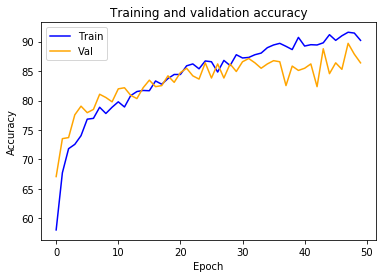

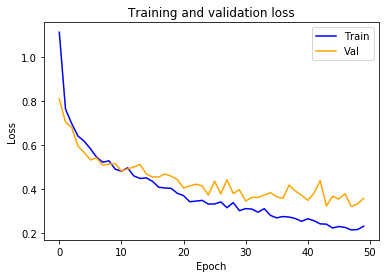

In [0]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [0]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from drive/My Drive/ADL/soccer_checkpoints/RNN/cp-00000049.ckpt


True label: replay
Predicted label: barcelona
Confidence of the prediction: 0.8308922


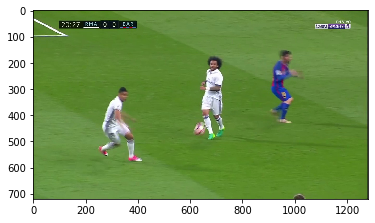

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.95875186


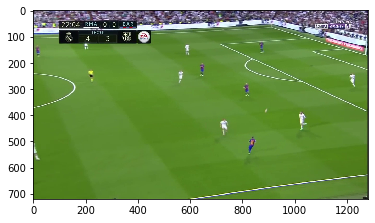

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.9740084


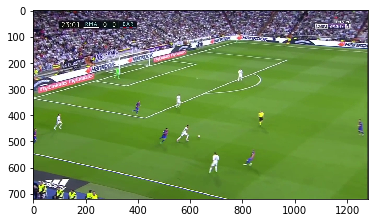

True label: death ball
Predicted label: death ball
Confidence of the prediction: 0.9974927


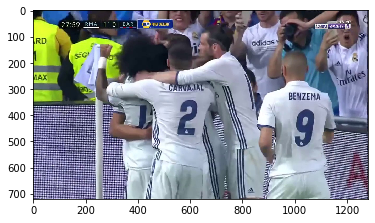

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.9668297


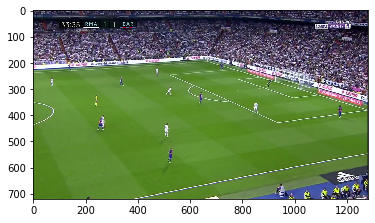

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.9881396


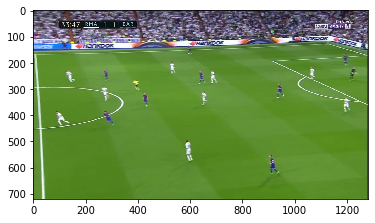

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.9428837


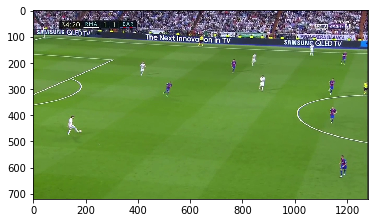

True label: replay
Predicted label: replay
Confidence of the prediction: 0.5683241


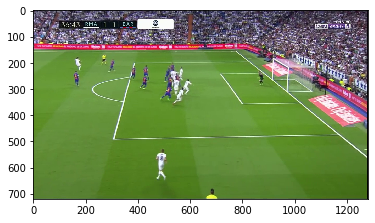

True label: death ball
Predicted label: barcelona
Confidence of the prediction: 0.9274828


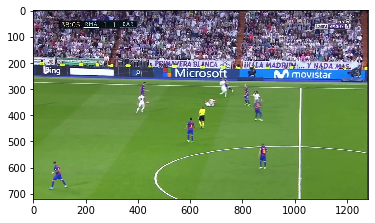

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.95977885


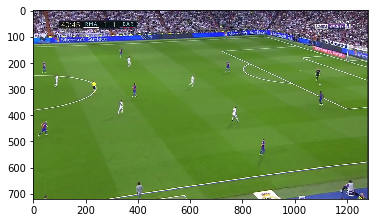

True label: barcelona
Predicted label: death ball
Confidence of the prediction: 0.7318241


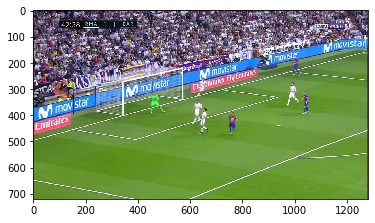

True label: real madrid
Predicted label: real madrid
Confidence of the prediction: 0.80768853


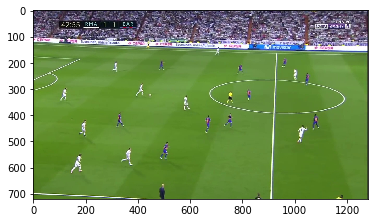

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.9992418


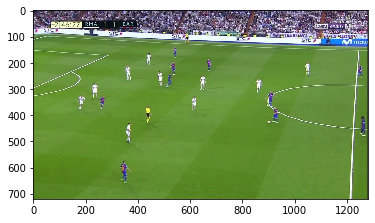

True label: replay
Predicted label: death ball
Confidence of the prediction: 0.9990464


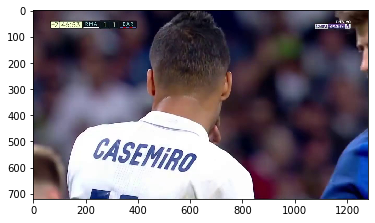

In [0]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [0]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.554986


In [0]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [0]:
predictions_rnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_rnn

img_path  frame  ...  pred_label  confidence
0     /content/clasico_frames/frame27200.jpg  27200  ...           0    0.999990
1     /content/clasico_frames/frame27210.jpg  27210  ...           0    0.999964
2     /content/clasico_frames/frame27220.jpg  27220  ...           0    0.999986
3     /content/clasico_frames/frame27230.jpg  27230  ...           0    0.999979
4     /content/clasico_frames/frame27240.jpg  27240  ...           0    1.000000
...                                      ...    ...  ...         ...         ...
5851  /content/clasico_frames/frame85710.jpg  85710  ...           3    0.980271
5852  /content/clasico_frames/frame85720.jpg  85720  ...           3    0.703831
5853  /content/clasico_frames/frame85730.jpg  85730  ...           2    0.824383
5854  /content/clasico_frames/frame85740.jpg  85740  ...           2    0.655800
5855  /content/clasico_frames/frame85750.jpg  85750  ...           3    0.946816

[5856 rows x 5 columns]

In [0]:
pred_labels = pd.Series(map(get_human_label, predictions_rnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_rnn['label']))

In [0]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred         barcelona  death ball  real madrid    replay       All
label                                                              
barcelona     0.233094    0.023224     0.072917  0.005123  0.334358
death ball    0.049010    0.129781     0.026469  0.042691  0.247951
real madrid   0.145321    0.007343     0.061646  0.003415  0.217725
replay        0.032616    0.030055     0.006318  0.130977  0.199966
All           0.460041    0.190403     0.167350  0.182206  1.000000

#### Recall

In [0]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.697140    0.069459     0.218080  0.015322
death ball    0.197658    0.523416     0.106749  0.172176
real madrid   0.667451    0.033725     0.283137  0.015686
replay        0.163108    0.150299     0.031597  0.654996

#### Precision

In [0]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.506682    0.121973     0.435714  0.028116
death ball    0.106533    0.681614     0.158163  0.234302
real madrid   0.315887    0.038565     0.368367  0.018744
replay        0.070898    0.157848     0.037755  0.718838

## Scene-based Approach

Scene-based approach means that we will be utilizing "scenes" instead of singular frames. Scenes are build up over 6 sequential frames (2 seconds of real-time) where the game state is constant over all 6 frames. No two scenes can share any frames.

### Pipeline changes due to scene vs image loading

In [0]:
labels_path = os.path.join(drive_root, "labels_scene.csv")
labels_df = pd.read_csv(labels_path)
labels_ = labels_df.copy()

labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * 3)
labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

frame  label                                img_path
0         0      0      /content/clasico_frames/frame0.jpg
1        60      0     /content/clasico_frames/frame60.jpg
2       120      0    /content/clasico_frames/frame120.jpg
3       180      0    /content/clasico_frames/frame180.jpg
4       240      0    /content/clasico_frames/frame240.jpg
...     ...    ...                                     ...
1339  85490      3  /content/clasico_frames/frame85490.jpg
1340  85550      3  /content/clasico_frames/frame85550.jpg
1341  85610      3  /content/clasico_frames/frame85610.jpg
1342  85670      3  /content/clasico_frames/frame85670.jpg
1343  85730      3  /content/clasico_frames/frame85730.jpg

[1344 rows x 3 columns]

Train/test split on only scenes





In [0]:
labels_df = labels_df.sample(frac=1)
FRAME_THRESHOLD = int(labels_df.shape[0]*2/3)
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:]
train, val = train_test_split(train_val, test_size=0.2, random_state=2019)

#### Convert data to an appropiate batch format to train the model

In [0]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

#modify to return past 2 seconds of activations instead of just 1 frame
def load_np(img_path, label):
    img_number = int(img_path.decode('utf-8').split('/')[3][5:-4])
    activation_0 = np.load(img_path.decode('utf-8')+'.npy')
    activation_1 = np.load(img_path.decode('utf-8').replace(
        str(img_number+10), str(img_number)) + '.npy')
    activation_2 = np.load(img_path.decode('utf-8').replace(
        str(img_number+20), str(img_number)) + '.npy')
    activation_3 = np.load(img_path.decode('utf-8').replace(
        str(img_number+30), str(img_number)) + '.npy')
    activation_4 = np.load(img_path.decode('utf-8').replace(
        str(img_number+40), str(img_number)) + '.npy')
    activation_5 = np.load(img_path.decode('utf-8').replace(
        str(img_number+50), str(img_number)) + '.npy')
    activations = np.dstack((activation_0, activation_1, activation_2, 
                            activation_3, activation_4, activation_5))
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
train_ds = create_dataset(images_train, labels_train)
val_ds = create_dataset(images_val, labels_val)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [0]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

(32, 8, 8, 12288) (32,) (32,)


### Design the model

In [0]:
image_input = Input(shape=(8, 8, 2048*6)) #must multiply input by 6 in scene 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [0]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 12288)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                786496    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 790,916
Trainable params: 790,916
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

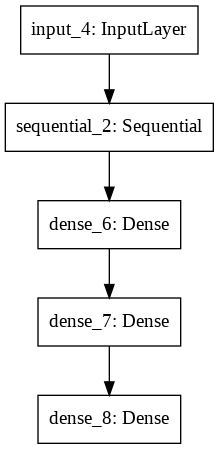

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [0]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [0]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [0]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.003418
Accuracy: 1.000000


In [0]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[1.0038913e-02 1.2768270e-03 9.8853683e-01 1.4746173e-04] 2.0
[6.3996320e-04 1.7945771e-04 9.9892610e-01 2.5444693e-04] 2.0
[3.4721202e-04 3.6705071e-05 3.1462876e-04 9.9930143e-01] 3.0
[9.9887294e-01 6.6980618e-05 9.5891143e-04 1.0112826e-04] 0.0
[5.0744222e-04 1.9434594e-04 2.5231313e-04 9.9904579e-01] 3.0
[5.3851547e-08 9.9959105e-01 4.0892881e-04 5.1670721e-08] 1.0
[9.9319530e-01 1.5886759e-05 6.6450965e-03 1.4367576e-04] 0.0
[2.3550373e-03 8.9817296e-04 9.9668890e-01 5.7872639e-05] 2.0
[9.9038202e-01 1.3094028e-03 8.1051961e-03 2.0334907e-04] 0.0
[1.3225179e-03 2.3552026e-03 9.9624276e-01 7.9562633e-05] 2.0
[2.4992414e-04 7.4999909e-05 1.2953188e-04 9.9954551e-01] 3.0
[9.9868435e-01 7.2412981e-06 2.9687013e-04 1.0114693e-03] 0.0
[3.3978757e-03 2.8565907e-04 9.9577820e-01 5.3820421e-04] 2.0
[9.8863912e-01 1.4051614e-05 1.0996036e-02 3.5076009e-04] 0.0
[3.4176980e-04 9.9735403e-01 2.2507946e-03 5.3416181e-05] 1.0
[0.00378571 0.00154519 0.9929791  0.00169004] 2.0
[9.9529934e-01 1.900

### Manage checkpoints in case we want to fit the model for a long time

In [0]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/SCENE")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is drive/My Drive/ADL/soccer_checkpoints/SCENE
Creating a checkpoints directory


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Fit the model

In [0]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [0]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 2.28, Accuracy: 43.80, Val Loss 1.11, Val Accuracy 56.67, Time: 5.4 secs
Saving weights
Epoch 1, Loss: 1.03, Accuracy: 58.47, Val Loss 0.96, Val Accuracy 57.22, Time: 4.9 secs
Saving weights
Epoch 2, Loss: 0.87, Accuracy: 64.54, Val Loss 0.97, Val Accuracy 57.22, Time: 4.9 secs
Saving weights
Epoch 3, Loss: 0.77, Accuracy: 69.16, Val Loss 0.79, Val Accuracy 66.11, Time: 5.0 secs
Saving weights
Epoch 4, Loss: 0.69, Accuracy: 74.46, Val Loss 0.77, Val Accuracy 67.22, Time: 4.9 secs
Saving weights
Epoch 5, Loss: 0.62, Accuracy: 76.31, Val Loss 0.84, Val Accuracy 65.00, Time: 4.9 secs
Saving weights
Epoch 6, Loss: 0.63, Accuracy: 75.50, Val Loss 0.75, Val Accuracy 67.78, Time: 4.9 secs
Saving weights
Epoch 7, Loss: 0.58, Accuracy: 77.45, Val Loss 0.80, Val Accuracy 65.00, Time: 5.0 secs
Saving weights
Epoch 8, Loss: 0.50, Accuracy: 80.75, Val Loss 0.78, Val Accuracy 68.33, Time: 4.9 secs
Saving weights
Epoch 9, Loss: 0.48, Accuracy: 82.07, Val Loss 1.15, Val Accuracy 54.44, 

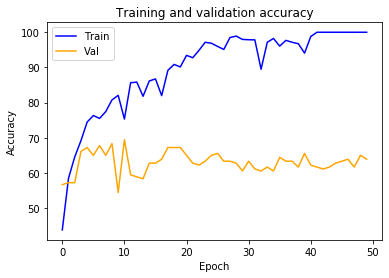

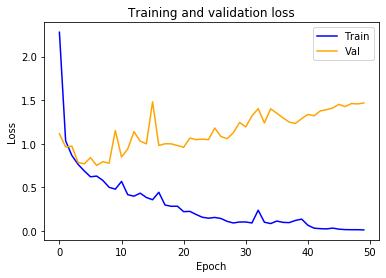

In [0]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [0]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from drive/My Drive/ADL/soccer_checkpoints/SCENE/cp-00000049.ckpt


In [0]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [0]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.600446


In [0]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [0]:
predictions_scene = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_scene

img_path  frame  ...  pred_label  confidence
0    /content/clasico_frames/frame61750.jpg  61750  ...           3    0.951387
1    /content/clasico_frames/frame25620.jpg  25620  ...           1    0.995677
2    /content/clasico_frames/frame83440.jpg  83440  ...           2    1.000000
3    /content/clasico_frames/frame25140.jpg  25140  ...           2    0.601108
4    /content/clasico_frames/frame43240.jpg  43240  ...           2    0.973074
..                                      ...    ...  ...         ...         ...
443  /content/clasico_frames/frame46680.jpg  46680  ...           1    0.996703
444  /content/clasico_frames/frame51970.jpg  51970  ...           3    0.756165
445  /content/clasico_frames/frame61970.jpg  61970  ...           2    0.921128
446  /content/clasico_frames/frame43550.jpg  43550  ...           1    0.986556
447  /content/clasico_frames/frame59870.jpg  59870  ...           3    0.527235

[448 rows x 5 columns]

In [0]:
pred_labels = pd.Series(map(get_human_label, predictions_scene['pred_label']))
labels = pd.Series(map(get_human_label, predictions_scene['label']))

In [0]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred         barcelona  death ball  real madrid    replay       All
label                                                              
barcelona     0.200893    0.011161     0.091518  0.000000  0.303571
death ball    0.029018    0.122768     0.042411  0.029018  0.223214
real madrid   0.111607    0.011161     0.127232  0.015625  0.265625
replay        0.013393    0.035714     0.008929  0.149554  0.207589
All           0.354911    0.180804     0.270089  0.194196  1.000000

#### Recall

In [0]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.661765    0.036765     0.301471  0.000000
death ball    0.130000    0.550000     0.190000  0.130000
real madrid   0.420168    0.042017     0.478992  0.058824
replay        0.064516    0.172043     0.043011  0.720430

#### Precision

In [0]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.566038    0.061728     0.338843  0.000000
death ball    0.081761    0.679012     0.157025  0.149425
real madrid   0.314465    0.061728     0.471074  0.080460
replay        0.037736    0.197531     0.033058  0.770115

## NOTEBOOK COMPLETE